In [1]:
from pathlib import Path
import pickle
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap

runs_path = Path('../runs_fanfics')
model_names = [
               'EleutherAI/pythia-160m', 'EleutherAI/pythia-410m', 'EleutherAI/pythia-1.4b',
               #'EleutherAI/pythia-2.8b',
               #'facebook/opt-1.3b', 'allenai/OLMo-1B-0724-hf',
               #'princeton-nlp/Sheared-LLaMA-1.3B',
               'meta-llama/Llama-3.2-1B', 'meta-llama/Llama-3.2-3B', 'meta-llama/Meta-Llama-3.1-8B',
               ]
data = {}

n_mem_tokens_list = [1]#, 16, 32, 64, 128]

metric = 'best_accuracy'

# Read all results for each model
for model_name in model_names:
    data[model_name] = {}
    for file_path in (runs_path / model_name).glob('mem_*_len_*.pkl'):
        file_name = file_path.stem
        if 'rnd' in file_name:
            continue
        n_mem_tokens = int(file_name.split('_')[1])
        length = int(file_name.split('_')[3])
        if n_mem_tokens not in n_mem_tokens_list:
            continue
        try:
            samples = pickle.load(open(file_path, 'rb'))
        except:
            continue
        
        avg_best_loss = np.mean([sample[metric] for sample in samples])
        compression_ratio = length / n_mem_tokens
        
        if n_mem_tokens not in data[model_name]:
            data[model_name][n_mem_tokens] = {'compression_ratios': [], 'losses': [], 'lengths': []}
        data[model_name][n_mem_tokens]['lengths'].append(length)
        data[model_name][n_mem_tokens]['compression_ratios'].append(compression_ratio)
        data[model_name][n_mem_tokens]['losses'].append(avg_best_loss)

max_lengths = {}
for mn in model_names:
    max_length = 0
    for metric_value, length in zip(data[mn][n_mem_tokens]['losses'], data[mn][n_mem_tokens]['lengths']):
        if metric_value >= 0.99:
            max_length = max(max_length, length)
    max_lengths[mn] = max_length

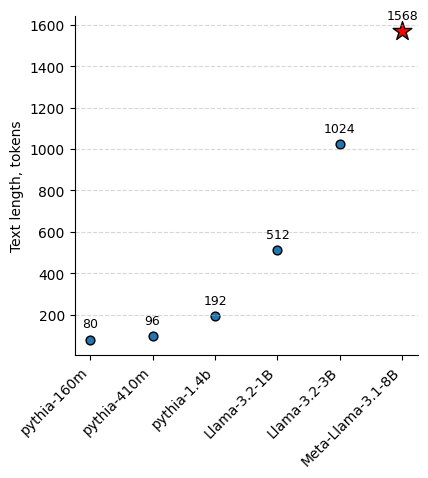

In [2]:
# ------------------------------------------------------------------------------
# Plotting code
# ------------------------------------------------------------------------------
# Extract the list of models and their corresponding max lengths (non-zero only)
models_with_data = []
lengths_for_plot = []
for mn in model_names:
    if mn in max_lengths and max_lengths[mn] > 0:
        # Use only the part of the string after the slash, e.g. "pythia-160m" etc.
        models_with_data.append(mn.split('/', 1)[-1])
        lengths_for_plot.append(max_lengths[mn])

# Numeric positions on the x-axis
x_positions = np.arange(len(models_with_data))

fig, ax = plt.subplots(figsize=(4.5, 5))

# 1) Identify the last (rightmost) index that has the maximum value
if len(lengths_for_plot) > 0:
    overall_max_value = max(lengths_for_plot)
    # Collect indices where the value = overall_max_value
    max_indices = [i for i, val in enumerate(lengths_for_plot) if val == overall_max_value]
    # The "last one with the highest value"
    last_max_index = max_indices[-1]

    # 2) Separate points into "regular" and "star" (the star is only for the last max index)
    regular_x = []
    regular_y = []
    star_x = []
    star_y = []

    for i, val in enumerate(lengths_for_plot):
        if i == last_max_index:
            star_x.append(x_positions[i])
            star_y.append(val)
        else:
            regular_x.append(x_positions[i])
            regular_y.append(val)

    # 3) Plot regular points as dots
    ax.scatter(regular_x, regular_y,
               marker='o', s=40, color='#1f77b4',
               edgecolors='black', linewidths=1)

    # 4) Plot the last max point as a star
    ax.scatter(star_x, star_y,
               marker='*', s=200, color='red',
               edgecolors='black', linewidths=1)

    # 5) Labeling each point
    for i, length_val in enumerate(lengths_for_plot):
        ax.text(
            x_positions[i], length_val + 45.0,  # slight vertical offset
            f"{length_val}",
            ha='center', va='bottom', fontsize=9
        )

# Set the ticks and labels
ax.set_xticks(x_positions)
ax.set_xticklabels(models_with_data, rotation=45, ha='right')

ax.set_ylabel("Text length, tokens")
# ax.set_title("How many tokens fit into a single input state?")

# -------------------------------------------------------------------
# Set custom y-axis ticks to powers of 2, for instance [64, 128, 256, 512, 1024, ...]
# -------------------------------------------------------------------
# custom_yticks = [256, 512, 1024, 1568, 2048, 4096, 8192, 16384, 32768]
# # If you want to filter out ticks above the max:
# filtered_yticks = [y for y in custom_yticks if y <= max(lengths_for_plot) + 200]
# ax.set_yticks(filtered_yticks)
# ax.set_yticklabels([str(y) for y in filtered_yticks])

# Clean up spines and add a light grid
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(axis='y', linestyle='--', alpha=0.5)

import matplotlib as mpl
mpl.rcParams['font.size'] = 14           # Base font size
mpl.rcParams['axes.labelsize'] = 14      # Axis label font size
mpl.rcParams['axes.titlesize'] = 14      # Title font size
mpl.rcParams['xtick.labelsize'] = 12     # X-axis tick label font size
mpl.rcParams['ytick.labelsize'] = 12     # Y-axis tick label font size
mpl.rcParams['legend.fontsize'] = 12     # Legend font size

plt.tight_layout()
# plt.savefig("imgs/results_brief_fanfics.pdf", format='pdf', bbox_inches='tight')
plt.show()

In [3]:
import pandas as pd

In [4]:
max_lengths

{'EleutherAI/pythia-160m': 80,
 'EleutherAI/pythia-410m': 96,
 'EleutherAI/pythia-1.4b': 192,
 'meta-llama/Llama-3.2-1B': 512,
 'meta-llama/Llama-3.2-3B': 1024,
 'meta-llama/Meta-Llama-3.1-8B': 1568}